# Import numpy, sep and establishing additional setup to read/display plots

In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io import fits 
import sep

## Open Image File

In [40]:
fname = "image.fits"
hdu_list = fits.open(fname)
hdu_list.info()

Filename: image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     337   (256, 256)   int16 (rescales to float32)   


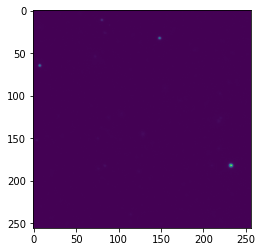

In [41]:
plt.imshow(hdu_list[0].data)

## View Image

6887.266 966.7967


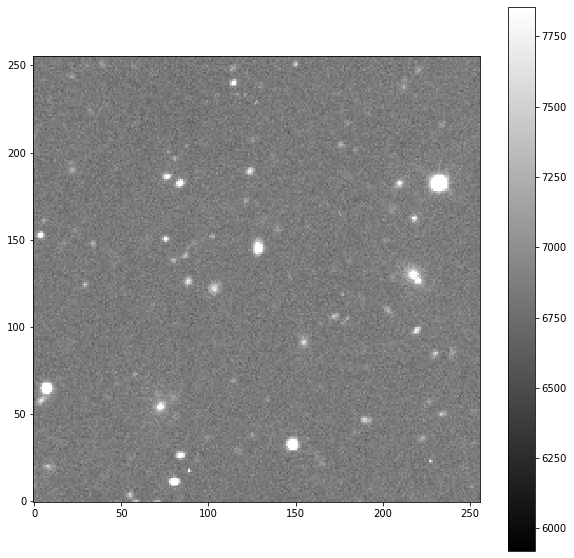

In [42]:
data = hdu_list[0].data
m, s = np.mean(data) , np.std(data)
print(m, s)
plt.figure(figsize=(10,10))
plt.imshow(data, interpolation='nearest' ,cmap='gray',  vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig('raw_data.png')

## Background Subtraction

In [43]:
bkg = sep.Background(data)

In [44]:
print(bkg.globalback)
print(bkg.globalrms)

6852.04931640625
65.46174621582031


In [45]:
bkg_image = bkg.back()

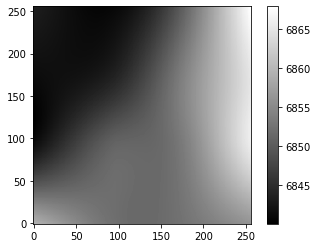

In [46]:
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [47]:
bkg_rms = bkg.rms()

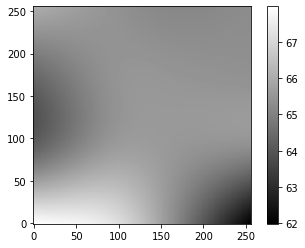

In [48]:
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [49]:
data_sub = data - bkg

## Object Detection

In [50]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [51]:
len(objects)

69

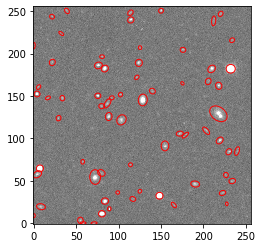

In [52]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [53]:
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

## Aperture Photometry

In [54]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [55]:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 2249.159297 +/- 291.027802
object 1: flux = 3092.220430 +/- 291.592204
object 2: flux = 5949.868379 +/- 356.562003
object 3: flux = 1851.426582 +/- 295.028816
object 4: flux = 72736.386914 +/- 440.172206
object 5: flux = 3860.756152 +/- 352.163162
object 6: flux = 6418.913789 +/- 357.458973
object 7: flux = 2210.707656 +/- 350.791223
object 8: flux = 2741.607227 +/- 352.277746
object 9: flux = 20916.875566 +/- 376.966138


## Open New Image File

In [56]:
fname = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
hdu_list = fits.open(fname)
hdu_list.info()

Filename: hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     359   (3600, 3600)   float32   


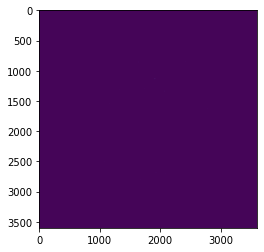

In [57]:
plt.imshow(hdu_list[0].data)

## Reduce the Noise

0.00079129904 0.054868452


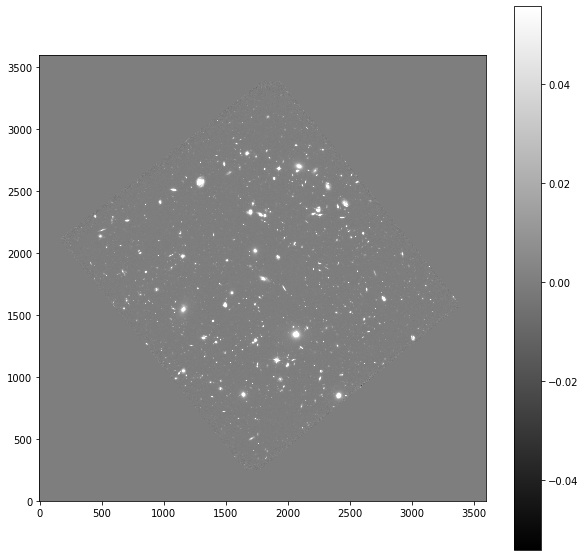

In [58]:
data = hdu_list[0].data
m, s = np.mean(data) , np.std(data)
print(m, s)
plt.figure(figsize=(10,10))
plt.imshow(data, interpolation='nearest' ,cmap='gray',  vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig('raw_data.png')


## Calculate the Background

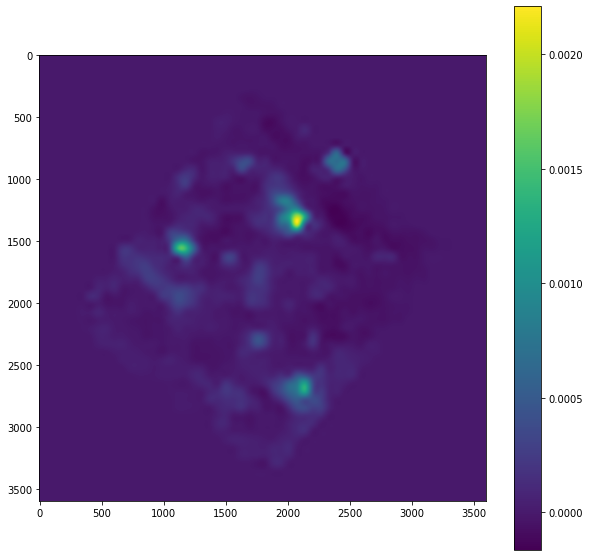

In [59]:
datasw = data.byteswap(False).newbyteorder() #big endian to little endian 
background = sep.Background(datasw)
plt.figure(figsize=(10,10))
plt.imshow(background)
plt.colorbar()
plt.savefig('Background.png')

## Visualize the Background Noise

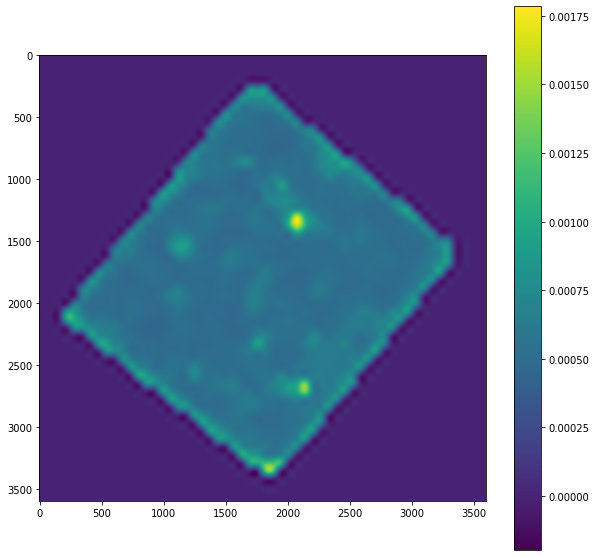

In [60]:
background_rms = background.rms()
plt.figure(figsize=(10,10))
plt.imshow(background_rms)
plt.colorbar()
plt.savefig('background_rms.png')

## Subtract Background From the Image

In [61]:
data_sub = data - background

## Identify the Data (objects)

In [62]:
objects = sep.extract(data_sub, 1.5, err=background.globalrms)
#how obj's found
len(objects)

8645

## 8640 Objects Found

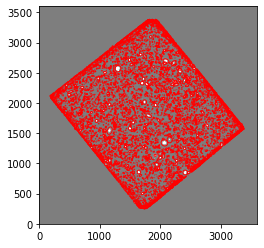

In [63]:
from matplotlib.patches import Ellipse 

#plot the image without the background
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('detected_sources.png')

## Flux Histogram

In [64]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects ['y'], 3.0, err=background.globalrms, gain=1.0)

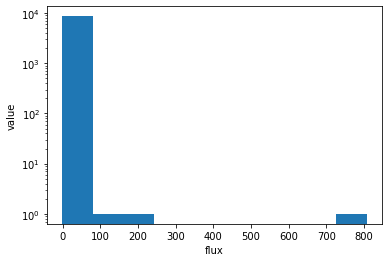

<Figure size 720x720 with 0 Axes>

In [65]:
plt.hist(flux)
plt.xlabel('flux')
plt.ylabel('value')
plt.yscale('log')
plt.figure(figsize=(10,10))
plt.show()